In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import data_gen as dg
import ising as isg

import jax
import jax.numpy as jnp
import optax
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [2]:
def langevin_step(sample, theta, eps, key):

    noise = jax.random.normal(key)
    grad = sample - theta

    return sample - eps * grad + jnp.sqrt(2 * eps) * noise

In [3]:
def langevin_evolve_batch(samples, theta, eps, keys_total, n_evolution, plot):

    evolved = samples.copy()

    for t in range(n_evolution):
        keys_t = keys_total[:, t]
        evolved = jax.vmap(langevin_step, in_axes = (0, None, None, 0))(evolved, theta, eps, keys_t)

    if plot:
        samples_np = np.array(samples)
        evolved_np = np.array(evolved)
        kde_samples = gaussian_kde(samples_np)
        kde_evolved = gaussian_kde(evolved_np)

        x_grid = np.linspace(min(samples_np.min(), evolved_np.min()) - 1, max(samples_np.max(), evolved_np.max())+1, 500)

        plt.figure(figsize = (6, 4))
        plt.plot(x_grid, kde_samples(x_grid), label = "start")
        plt.plot(x_grid, kde_evolved(x_grid), label = "start")
        plt.title(theta)
        plt.show

    return evolved

In [4]:
def loss_euc(theta, samples, eps, keys_total, n_evolution):

    evolved = langevin_evolve_batch(samples, theta, eps, keys_total, n_evolution, plot = False)

    return jnp.mean(jnp.linalg.norm(evolved - samples)**2)

In [5]:
def rbf_kernel(x, y, gamma):

    diff = x - y
    
    return jnp.exp(-gamma * jnp.sum(diff**2))

In [6]:
def pairwise_squared_distances(samples_x, samples_y):

    def distance_fn(x, y):
        return jnp.sum((x - y) ** 2)
    
    return jax.vmap(lambda x: jax.vmap(lambda y: distance_fn(x, y))(samples_y))(samples_x)


In [7]:
def median_heuristic(samples_x, samples_y):

    sq_dists = pairwise_squared_distances(samples_x, samples_y)
    
    return 1 / (jnp.sqrt(jnp.median(sq_dists)))

In [8]:
def compute_mmd_squared(samples_x, samples_y, gamma=None):

    n = samples_x.shape[0]
    m = samples_y.shape[0]

    if gamma is None:
        gamma = median_heuristic(samples_x, samples_y)

    def kxx(i, j):
        return rbf_kernel(samples_x[i], samples_x[j], gamma)

    def kyy(i, j):
        return rbf_kernel(samples_y[i], samples_y[j], gamma)

    def kxy(i, j):
        return rbf_kernel(samples_x[i], samples_y[j], gamma)
    k_xx = jnp.mean(jnp.array([[kxx(i, j) for j in range(n)] for i in range(n)]))
    k_yy = jnp.mean(jnp.array([[kyy(i, j) for j in range(m)] for i in range(m)]))
    k_xy = jnp.mean(jnp.array([[kxy(i, j) for j in range(m)] for i in range(n)]))

    return (k_xx + k_yy - 2 * k_xy)

In [9]:
def loss_gauss(theta, samples, eps, keys_total, n_evolution, gamma):

    evolved = langevin_evolve_batch(samples, theta, eps, keys_total, n_evolution, plot = False)

    return compute_mmd_squared(samples, evolved, gamma)

In [10]:
def generate_samples(n_samples, seed):

    key = jax.random.PRNGKey(seed)
    key, key_samples = jax.random.split(key)
    samples = jax.random.normal(key_samples, shape = (n_samples,)) - 10.0

    return samples

In [11]:
def train_langevin_matching(samples, n_evolution = 100, n_iterations = 100, eps = 0.01, lr = 0.1, seed = 1):

    key = jax.random.PRNGKey(seed)
    n_samples = len(samples)
    theta = jnp.array(-10.0 - 1)
    opt = optax.adam(lr)
    opt_state = opt.init(theta)
    losses = []

    for epoch in range(n_iterations):
        key, subkey = jax.random.split(key)
        keys_flat = jax.random.split(subkey, n_samples * n_evolution)
        keys_total = keys_flat.reshape((n_samples, n_evolution, 2))

        # loss_val, grad_val = jax.value_and_grad(loss_euc)(theta, samples, eps, keys_total, n_evolution)
        loss_val, grad_val = jax.value_and_grad(loss_gauss)(theta, samples, eps, keys_total, n_evolution, gamma = None)

        if epoch % 1 == 0:
            print(f"epoch {epoch:3d} | theta = {theta:4f} | grad = {grad_val:.4f} | loss = {loss_val: .4f}")
            evolved = langevin_evolve_batch(samples, theta, eps, keys_total, n_evolution, plot = True)
            losses.append(loss_val.item())

        updates, opt_state = opt.update(grad_val, opt_state)
        theta = optax.apply_updates(theta, updates)

    return theta, losses

epoch   0 | theta = -11.000000 | grad = -0.2705 | loss =  0.1910
epoch   1 | theta = -10.900001 | grad = -0.1949 | loss =  0.0835


KeyboardInterrupt: 

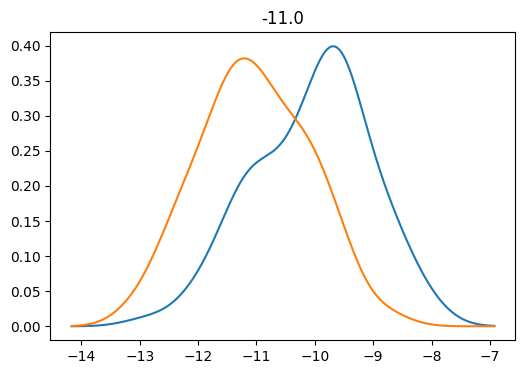

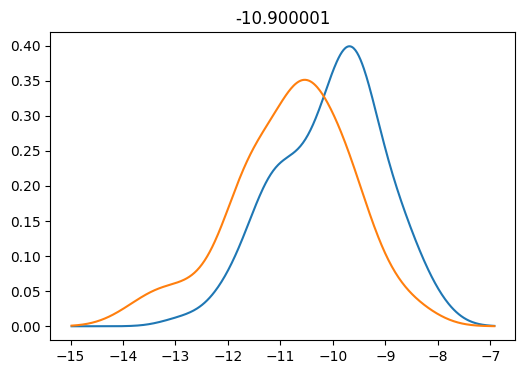

In [12]:
samples = generate_samples(100, 100)

final_theta, losses = train_langevin_matching(samples, n_evolution = 200, n_iterations = 500, eps = 1e-2, lr = 1e-1, seed = 1)